In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ExifTags
from sam2.build_sam import build_sam2_video_predictor

# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


# def show_points(coords, labels, ax, marker_size=200):
#     pos_points = coords[labels==1]
#     neg_points = coords[labels==0]
#     ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
#     ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

def get_image_orientation(filepath):
    """이미지의 EXIF 정보를 읽어 방향을 반환합니다."""
    image = Image.open(filepath)
    orientation = None
    try:
        exif = image._getexif()
        if exif:
            for tag, value in exif.items():
                if ExifTags.TAGS.get(tag) == 'Orientation':
                    orientation = value
                    break
    except (AttributeError, KeyError, IndexError):
        pass
    return orientation

def process_images_in_folder(input_folder, output_folder, point1, point2):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 이미지 프레임 이름 목록 가져오기
    frame_names = [
        p for p in os.listdir(input_folder)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    # 초기화
    inference_state = predictor.init_state(video_path=input_folder)
    predictor.reset_state(inference_state)

    # 2. Two Clicks
    ann_frame_idx = 0
    ann_obj_id = 1

    ###### 이미지 비율로 처리 ######
    first_frame_path = os.path.join(input_folder, frame_names[0])
    image_size = get_image_size(first_frame_path)
    point1 = [point1[0] * image_size[0], point1[1]*image_size[1]]
    point2 = [point2[0] * image_size[0], point2[1]*image_size[1]]

    points = np.array([point1, point2], dtype=np.float32)
    labels = np.array([1, 1], np.int32)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )

    # 비디오 내 모든 프레임에 대해 전파
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    # 프레임에 대해 시각화 및 마스크 저장
    vis_frame_stride = 1
    plt.close("all")
    for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
        if out_frame_idx in video_segments:
            frame_path = os.path.join(input_folder, frame_names[out_frame_idx])
            frame_image = Image.open(frame_path)
            orientation = get_image_orientation(frame_path)
            frame_image = np.array(frame_image)
            
            plt.figure(figsize=(6, 4))
            plt.title(f"frame {out_frame_idx}")
            plt.imshow(frame_image)

            masks = []
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
                masks.append(out_mask)

            save_masks(frame_image, masks, output_folder, frame_names[out_frame_idx], orientation)

def save_masks(image, out_masks, output_folder, original_filename, orientation):
    # 마스크 처리
    black_background = np.zeros_like(image)

    # Iterate through each mask and save
    for i, out_mask in enumerate(out_masks):
        # 마스크의 차원이 3차원인 경우 2차원으로 축소
        if len(out_mask.shape) == 3 and out_mask.shape[0] == 1:
            out_mask = out_mask.squeeze(0)

        # 마스크를 이미지와 동일한 shape로 확장
        mask_expanded = out_mask[:, :, np.newaxis]  # (2268, 4032, 1)

        # 마스크를 사용하여 이미지와 배경을 결합
        masked_image = np.where(mask_expanded, image, black_background)

        # PIL 이미지로 변환
        masked_image_pil = Image.fromarray(masked_image.astype(np.uint8))

        # EXIF 방향 정보를 적용
        if orientation:
            if orientation == 3:
                masked_image_pil = masked_image_pil.rotate(180, expand=True)
            elif orientation == 6:
                masked_image_pil = masked_image_pil.rotate(270, expand=True)
            elif orientation == 8:
                masked_image_pil = masked_image_pil.rotate(90, expand=True)

        # 파일 이름 수정 및 저장
        base_filename, ext = os.path.splitext(original_filename)
        output_filename = f"{base_filename}_masked_{i}.png"
        output_path = os.path.join(output_folder, output_filename)
        
        masked_image_pil.save(output_path)

def clear_gpu_memory():
    # 명시적으로 메모리에서 변수 삭제
    del sam2_model
    del predictor
    torch.cuda.empty_cache()  # 캐시된 메모리 해제

propagate in video: 100%|█████████████████████████████████| 13/13 [00:01<00:00,  9.08it/s]


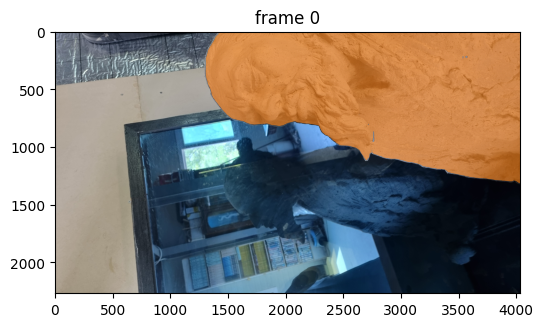

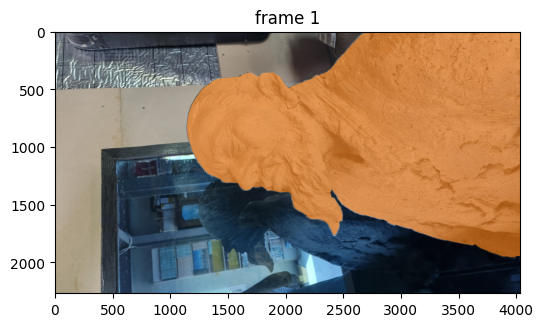

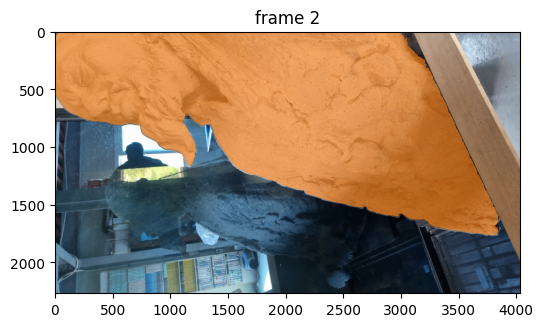

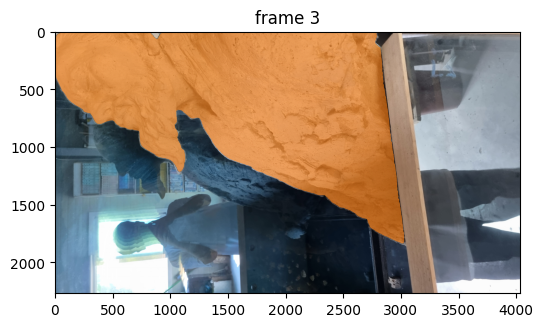

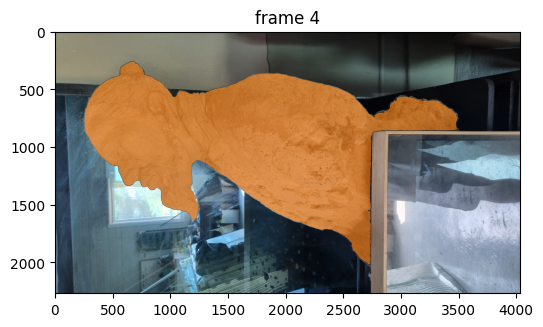

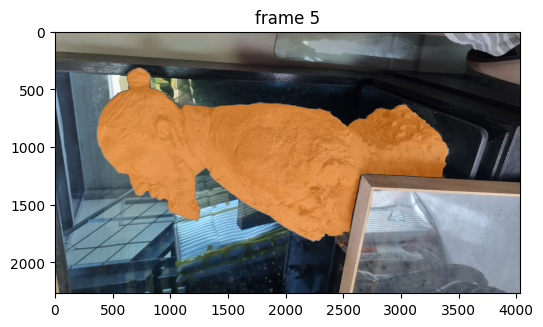

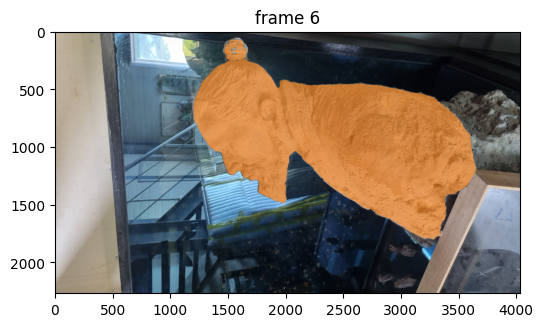

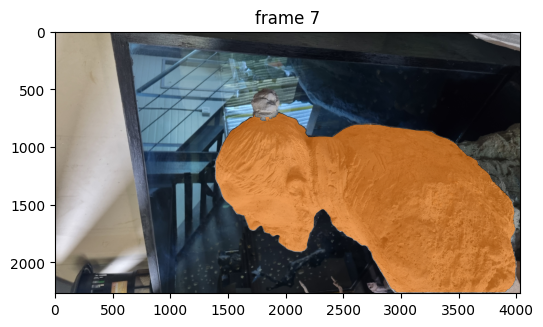

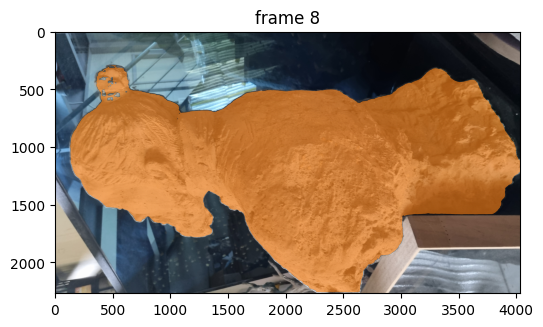

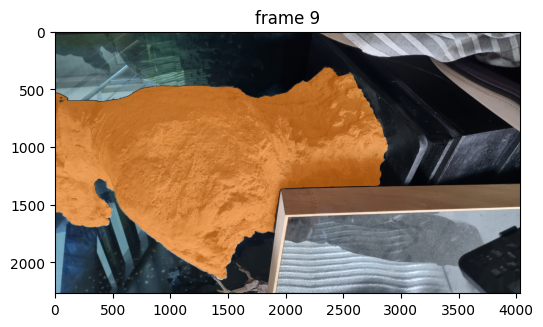

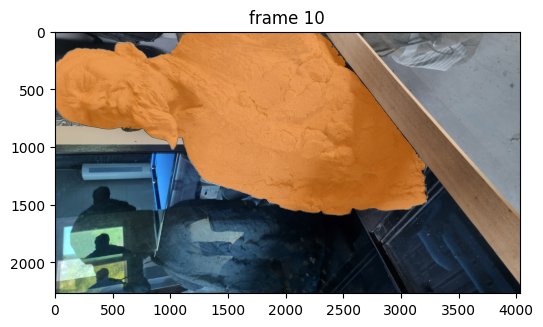

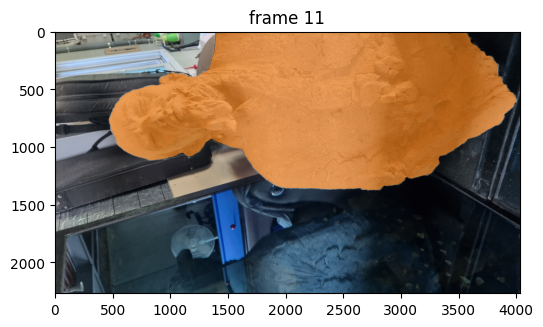

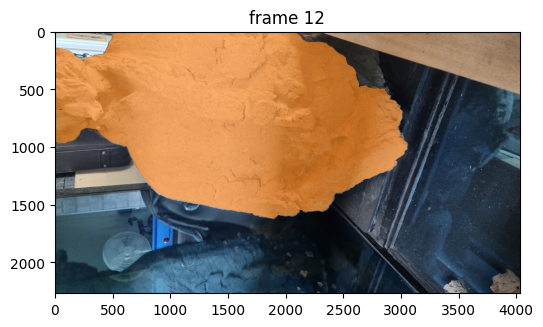

In [7]:
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

input_folder = "./videos/statue/input"
output_folder = "./videos/statue/output"
point1 = [0.7,0.25]
point2 = [0.5,0.25]
process_images_in_folder(input_folder, output_folder, point1, point2)

In [21]:
clear_gpu_memory()

UnboundLocalError: local variable 'sam2_model' referenced before assignment